<a href="https://colab.research.google.com/github/quagrain/quagrain/blob/main/OVR_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [443]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBRegressor
from google.colab import drive
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_21 = '/content/drive/My Drive/Colab Notebooks/datasets/players_21.csv'
path_22 = '/content/drive/My Drive/Colab Notebooks/datasets/players_22.csv'

with open(path_21) as dataset_21, open(path_22) as dataset_22:
    fifa_21 = pd.read_csv(path_21)
    fifa_22 = pd.read_csv(path_22)

print("\nFIFA 21 Dataset Shape: " + str(fifa_21.shape))
print("FIFA 22 Dataset Shape: " + str(fifa_22.shape) + "\n")

drop = []
for col in fifa_21.columns:
    missing = (len(fifa_21[col]) - fifa_21[col].count())/len(fifa_21[col]) * 100
    if missing > 30:
        print(f'{col} = {round(missing, 2)}%')
        drop.append(col)

fifa_21.drop(columns = drop, inplace = True)
fifa_22.drop(columns = drop, inplace = True)

print("\nFIFA 21 Dataset Shape: " + str(fifa_21.shape))
print("FIFA 22 Dataset Shape: " + str(fifa_22.shape) + "\n")


FIFA 21 Dataset Shape: (18944, 110)
FIFA 22 Dataset Shape: (19239, 110)

club_loaned_from = 96.0%
nation_team_id = 94.05%
nation_position = 94.05%
nation_jersey_number = 94.05%
player_tags = 92.57%
player_traits = 56.11%
goalkeeping_speed = 89.0%
nation_logo_url = 94.05%

FIFA 21 Dataset Shape: (18944, 102)
FIFA 22 Dataset Shape: (19239, 102)



<ipython-input-347-1624cfce9c3f>:6: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa_22 = pd.read_csv(path_22)


We are dropping all the columns that have more than 30% of their values missing because imputing them could create a bias.

In [ ]:
fifa_21.dtypes.head(60), fifa_21.dtypes.tail(50)

# **Exploratory Data Analysis**

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Player Age Distribution')

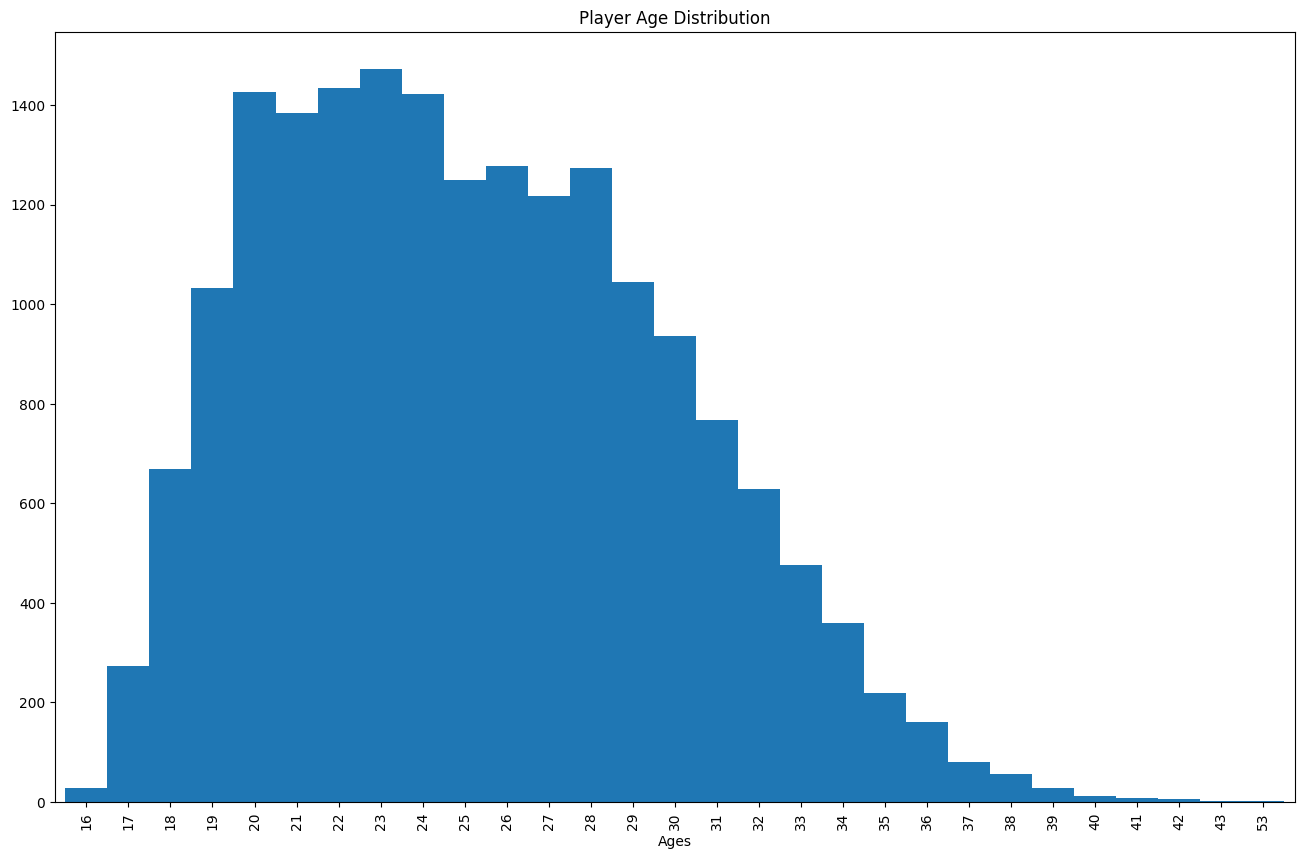

In [ ]:
age = fifa_21['age']
bins=np.arange(0, 60, 1)
pd.cut(age, bins=bins, labels=bins[1:]).astype(int).value_counts().sort_index().plot.bar(width=1, figsize=(16,10))
plt.xlabel('Ages')
plt.xticks(rotation=90)
plt.title('Player Age Distribution')

<Axes: xlabel='overall', ylabel='wage_eur'>

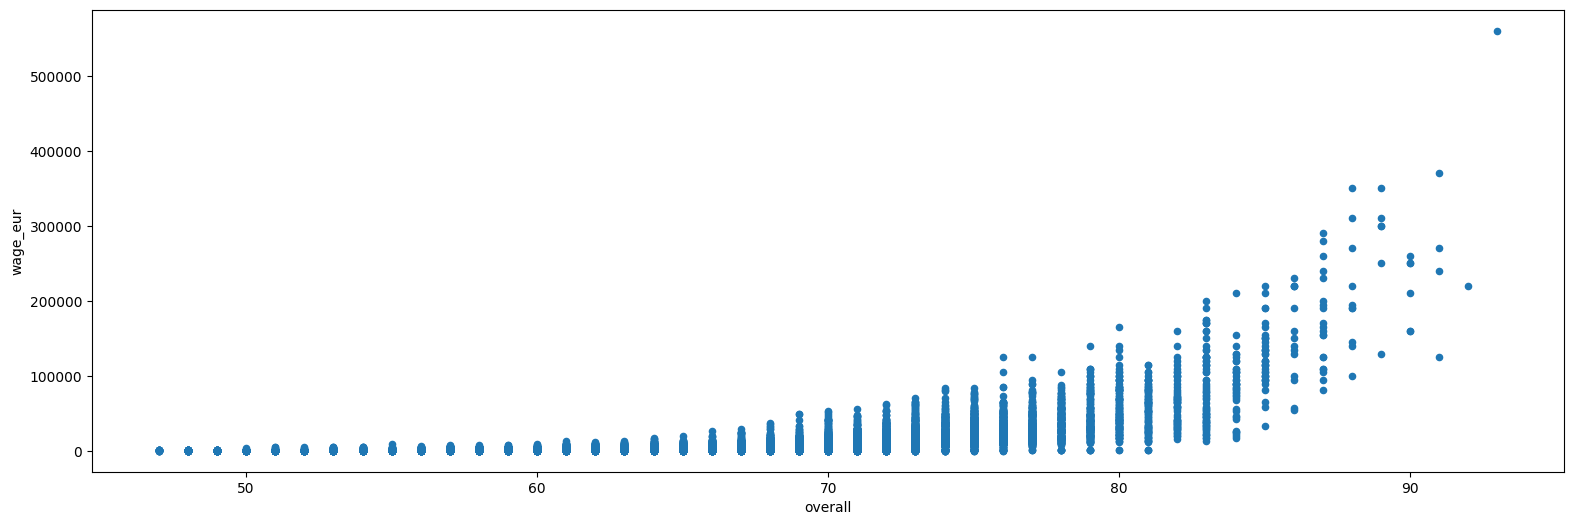

In [ ]:
fifa_21.plot(kind="scatter", x="overall", y="wage_eur", figsize=(19,6))

In [ ]:
fifa_21.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url',
       'club_logo_url', 'club_flag_url', 'nation_flag_url'],
      dtype='object', length=102)

In [ ]:
pd.DataFrame(positions.value_counts())

,club_position
681,3
553,2
425,2
420,2
248,2
224,2
170,2
8065,1
3163,1
452,1


# **Subsetting Data**

In [428]:
ovr_21 = fifa_21[['overall']]
ovr_22 = fifa_22[['overall']]
correlate = fifa_21.corr()['overall'].sort_values(ascending=False)
keys = correlate.keys()
values = correlate.values
keys_to_use = []
for key,val in zip(keys, values):
    if(val>0.4): # 0.1
        keys_to_use.append(key)
keys_to_use.remove('potential')
keys_to_use.remove('release_clause_eur')
keys_to_use.remove('wage_eur')
keys_to_use.remove('value_eur')
train_21 = fifa_21[keys_to_use]
train_22 = fifa_22[keys_to_use]

<ipython-input-428-72cea974c45a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlate = fifa_21.corr()['overall'].sort_values(ascending=False)


Imputation

In [429]:
imp = SimpleImputer()
imp.fit(train_21)
imputed_data=imp.fit_transform(train_21)
train_21=pd.DataFrame(imputed_data, columns=train_21.columns)

imputed_data = imp.fit_transform(train_22)
train_22=pd.DataFrame(imputed_data, columns=train_22.columns)

Encoding

In [430]:
# Use one hot encoding for the preferred foot because the values don't have any order
pref_foot_21 =pd.get_dummies(fifa_21['preferred_foot'])
pref_foot_22 =pd.get_dummies(fifa_22['preferred_foot'])

We used one hot encoding for the preferred foot because it has no order of magnitude

In [431]:
categorical = ['work_rate']
labels_21 = fifa_21[categorical]
labels_22 = fifa_22[categorical]
encoder = LabelEncoder()
labels_21 = pd.DataFrame(encoder.fit_transform(labels_21), columns = labels_21.columns)
labels_22 = pd.DataFrame(encoder.fit_transform(labels_22), columns = labels_22.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Scaling

In [432]:
sc = StandardScaler()
scaled = sc.fit_transform(train_21)
train_21 = pd.DataFrame(scaled, columns = train_21.columns)

scaled = sc.fit_transform(train_22)
train_22 = pd.DataFrame(scaled, columns = train_22.columns)

Randomise the arrangement of the rows in each dataframe

In [433]:
train_21 = train_21.sample(frac=1)
train_22 = train_22.sample(frac=1)

In [434]:
ovr_21 = train_21['overall']
ovr_22 = train_22['overall']
train_21.drop(columns='overall', inplace=True)
train_22.drop(columns='overall', inplace=True)

# **Model Training**

In [435]:
imputed_data=imp.fit_transform(train_21)
train_21=pd.DataFrame(imputed_data, columns=train_21.columns)

imputed_data = imp.fit_transform(train_22)
train_22=pd.DataFrame(imputed_data, columns=train_22.columns)

In [447]:
g_reg = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(n_estimators = 1000, verbosity = 1,max_depth = 5, gamma = 0.2, subsample = 0.2, learning_rate = 0.3)
sv = SVR()
svr_lin = SVR(kernel = 'linear')
svr_poly = SVR(kernel = 'poly')
l = LinearRegression()
br = BayesianRidge()
sg = SGDRegressor()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
vc = VotingRegressor(estimators=[('decision_tree', dt), ('knn', knn), ('svm', sv)])
vc_2 = VotingRegressor(estimators=[('random_forest', rf), ('xgb', xgb_reg), ('svm', sv)])

In [448]:
for reg in (rf, xgb_reg, g_reg, sv, svr_lin, svr_poly, l, br, sg, knn, dt, vc):
    reg.fit(train_21, ovr_21)
    y_pred = reg.predict(train_22)
    score = reg.score(train_21, ovr_21)
    mse = mean_squared_error(ovr_22, y_pred)
    mae = mean_absolute_error(ovr_22, y_pred)
    r2 = r2_score(ovr_22, y_pred)
    print(f"The {reg.__class__.__name__} model had {round(score, 4)} accuracy score, {round(mse, 4)} MSE, {round(mae, 4)} MAE and {round(r2, 4)} R2 Score")

The RandomForestRegressor model had 0.989 accuracy score, 0.0601 MSE, 0.1827 MAE and 0.9399 R2 Score
The XGBRegressor model had 0.965 accuracy score, 0.1231 MSE, 0.2589 MAE and 0.8769 R2 Score
The GradientBoostingRegressor model had 0.9144 accuracy score, 0.0868 MSE, 0.2253 MAE and 0.9132 R2 Score
The SVR model had 0.9424 accuracy score, 0.0601 MSE, 0.1823 MAE and 0.9399 R2 Score
The SVR model had 0.8512 accuracy score, 0.145 MSE, 0.2925 MAE and 0.855 R2 Score
The SVR model had 0.8658 accuracy score, 0.139 MSE, 0.2801 MAE and 0.861 R2 Score
The LinearRegression model had 0.8521 accuracy score, 0.1441 MSE, 0.2932 MAE and 0.8559 R2 Score
The BayesianRidge model had 0.8521 accuracy score, 0.1441 MSE, 0.2932 MAE and 0.8559 R2 Score
The SGDRegressor model had 0.852 accuracy score, 0.1443 MSE, 0.2936 MAE and 0.8557 R2 Score
The KNeighborsRegressor model had 0.935 accuracy score, 0.0841 MSE, 0.2209 MAE and 0.9159 R2 Score
The DecisionTreeRegressor model had 1.0 accuracy score, 0.1356 MSE, 0.2

In [438]:
train_21.columns

Index(['movement_reactions', 'passing', 'mentality_composure', 'dribbling',
       'power_shot_power', 'physic', 'mentality_vision',
       'attacking_short_passing', 'shooting', 'skill_long_passing', 'age',
       'skill_ball_control', 'international_reputation', 'skill_curve',
       'attacking_crossing', 'power_long_shots', 'mentality_aggression'],
      dtype='object')